Import all required modules

In [63]:
import sqlite3
import pandas as pd
from Data_modules import DataLoader, Visualizer, MissingValuesHandler

Initialize data modules

In [64]:
data_loader = DataLoader()
visual = Visualizer()
values_handler = MissingValuesHandler()

Load data from CSV

In [65]:
game_data = data_loader.load_data('Data/game_collection.csv')

game_data

,Game Title,Game Genre,Pricing,Developer,Release Date,Platform,Rating,Number of Ratings
0,! That Bastard Is Trying To Steal Our Gold !,"Action, Adventure, Casual, Indie",2.99,WTFOMGames,Mar 1 2016,PC,56.0,66
1,! Wild Russia !,"Action, Adventure, Casual",19.99,Andreev Worlds,Apr 28 2020,PC,61.0,60
2,!4RC4N01D!,Arcade,0.00,armogames,"Jan 12, 2018",PC,40.0,7
3,!4RC4N01D! 2: Retro Edition,Arcade,0.00,armogames,"Feb 6, 2018",PC,38.0,7
4,!4RC4N01D! 3: Cold Space,Arcade,0.00,armogames,"Mar 8, 2018",PC,30.0,7
...,...,...,...,...,...,...,...,...
61737,👑Idle Calibur：Zero💕（选王之剑：零）,"Indie, RPG, Simulation, Strategy",10.99,绝汪,Oct 31 2024,PC,85.0,261
61738,👾 Foreign Frugglers,"Action, Indie",4.99,Ultimo Games,Jun 26 2019,PC,100.0,10
61739,🔴 Circles,"Casual, Indie",0.00,Jeroen Wimmers,Feb 17 2017,PC,89.0,226
61740,🚀 Human Rocket Person,"Action, Indie, Simulation",1.99,2nd Studio,Nov 14 2018,PC,95.0,43


Lets get unique values of Platforms and Genres to use them in separate tables.

In [66]:
def get_platforms_and_genres_sets(data):
  platforms_set = set()
  genres_set = set()
  for i, row in data.iterrows():
    platforms = row['Platform'].split(', ')
    genres = row['Game Genre'].split(', ')
    for value in platforms:
      platforms_set.add(value)
    for value in genres:
      genres_set.add(value)
  return platforms_set, genres_set

platforms_set, genres_set = get_platforms_and_genres_sets(game_data)

print(platforms_set)
print(genres_set)

{'Nintendo 3DS', 'Xbox', 'PlayStation 2', 'Google Stadia', 'Wii U', 'PlayStation VR', 'Nintendo 64', 'Xbox One', 'iOS (iPhone/iPad)', 'Dreamcast', 'GameCube', 'PlayStation 4', 'HTC Vive', 'Wii', 'Nintendo Switch', 'Xbox Series X', 'PlayStation 3', 'PlayStation', 'Game Boy Advance', 'PlayStation Vita', 'Nintendo DS', 'Xbox Series X/S', 'Meta Quest', 'PSP', 'PC', 'PlayStation 5', 'Xbox 360'}
{'Rugby', '3D Fighting', "3D Beat-'Em-Up", 'Biking', 'Real-Time Strategy', 'Sports', 'Skating', 'Linear Action Adventure', 'Action RPG', 'Edutainment', 'Free To Play', 'Command RTS', 'Football', 'Volleyball', 'Space Combat Sim', 'Video Production', 'Auto Racing Sim', 'First-Person Adventure', 'Card Battle', 'Board', 'Hidden Object', 'Soccer Sim', 'Hockey Sim', 'Skiing', 'RPG', 'Marine Combat Sim', 'Fishing', 'Sandbox', 'Soccer', 'Survival', 'Console', 'Arcade', 'Application', 'Western RPG', 'Hunting', 'Gambling', '2D Platformer', 'Logic Puzzle', "Top-Down Shoot-'Em-Up", 'Matching Puzzle', 'Point-and-

Several functions to create  SQL database containing three tables, based on data loaded from CSV.

In [67]:
def create_table_games(cursor):
  cursor.execute('''
  CREATE TABLE IF NOT EXISTS Games (
  id INTEGER PRIMARY KEY,
  title TINYTEXT,
  genre TINYTEXT,
  pricing FLOAT,
  developer TINYTEXT,
  release_date DATE,
  platform TINYTEXT,
  rating FLOAT,
  rating_number INT
  )
  ''')

def create_table_genres(cursor):
  cursor.execute('''
  CREATE TABLE IF NOT EXISTS Genres (
  id INTEGER PRIMARY KEY,
  name TINYTEXT
  )
  ''')

def create_table_platforms(cursor):
  cursor.execute('''
  CREATE TABLE IF NOT EXISTS Platforms (
  id INTEGER PRIMARY KEY,
  name TINYTEXT
  )
  ''')

def load_table_games(connection):
  for i, row in game_data.iterrows():
      cursor.execute("INSERT INTO Games (title, genre, pricing, developer, release_date, platform, rating, rating_number) values (?, ?, ?, ?, ?, ?, ?, ?)", (row['Game Title'], row['Game Genre'], row['Pricing'], row['Developer'], row['Release Date'], row['Platform'], row['Rating'], row['Number of Ratings']))

def fill_table_genres(cursor):
  for name in genres_set:
      cursor.execute("INSERT INTO Genres (name) values (?)", (name,))

def fill_table_plaforms(cursor):
  for name in platforms_set:
      cursor.execute("INSERT INTO Platforms (name) values (?)", (name,))

Creating database.

In [68]:
connection = sqlite3.connect('Data/game_collection.db')
cursor = connection.cursor()

create_table_games(cursor)
load_table_games(connection)

create_table_genres(cursor)
fill_table_genres(cursor)

create_table_platforms(cursor)
fill_table_plaforms(cursor)

connection.commit()
connection.close()

Let's check ratings of free games for PC, for example:

                                  rating
Missing Amount                       0.0
Presented Amount                    8588
Presented Mode Value    78.0 (288 times)
Presented Mean Value           76.712855
Presented Median Value              80.0


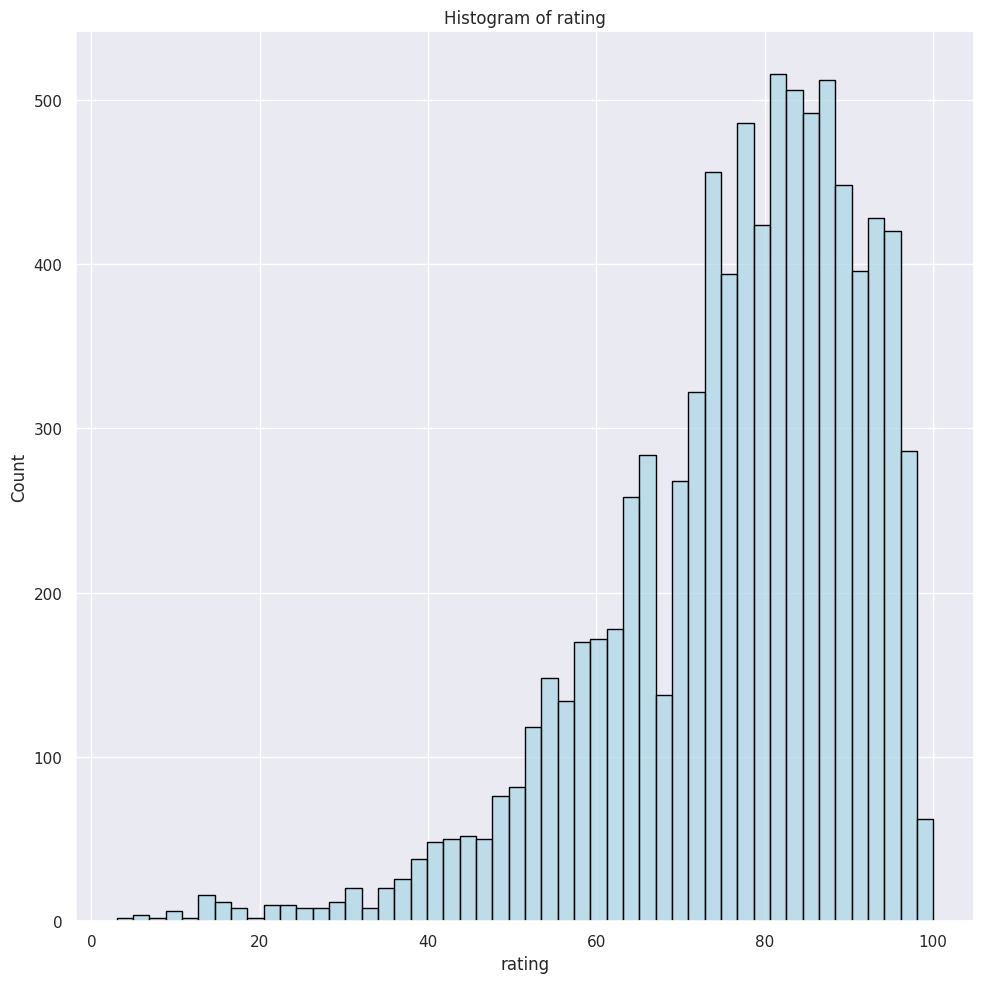

In [69]:

connection = sqlite3.connect('Data/game_collection.db')
cursor = connection.cursor()

cursor.execute('SELECT COUNT(title) FROM Games WHERE platform LIKE "%PC%" AND pricing = 0 AND rating_number > 100')

selected_data_amount = cursor.fetchall()

cursor.execute('SELECT title, rating FROM Games WHERE platform LIKE "%PC%" AND pricing = 0 AND rating_number > 100')

selected_data = cursor.fetchall()

connection.commit()
connection.close()

data_to_visualize = pd.DataFrame(selected_data, columns=['title', 'rating'])

values_handler.get_column_values_statistics(data_to_visualize, 'rating')
visual.show_histogram(data_to_visualize, 'rating')
